# MVP

The goal of this project is analyze the relationship between various features and gross domestic profit for the top 1000 grossing movies that never made it to #1 on the weekend box office. Virtually every weekend box office #1 movie is cut from the same cloth. Half(!) of the top 20 highest domestic grossing movies are either from Star Wars or The Avengers alone. This project is for the dreamers out there who might have a movie script in mind that's not a Super Hero trilogy, who might benefit from learning about trends that the most successful, but not mega-blockbuster movies had. 


To my instructors: Most of this notebook is boring scraping and EDA stuff. Towards the end you can find the first Linear Regression modelling I've done. The R^2 is one of the worst I've seen! Heh, but I learned a lot this week and hopefully can improve these results and incorporate more features. 

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [ ]:
url = 'https://www.boxofficemojo.com/chart/never_in_top/?by_rank_threshold=1&ref_=bo_cso_ac'

response = requests.get(url)
page = response.text

soup = BeautifulSoup(page,"lxml")

table = soup.find('table')
rows = [row for row in table.find_all("tr")]


movies = {}    # dict

for row in rows[1:]:        
    items = row.find_all('td')
    link = items[1].find('a')
    title, url = link.text.split('- Box')[0].strip(), link['href']    # instead of link.text.split('-') 
    movies[title] = [url] + [i.text for i in items]
    
movies

In [ ]:
# now do scroll pages (P2 to P6, up to 1200 movies)

for i in range(200, 801, 200):  
    url = "https://www.boxofficemojo.com/chart/never_in_top/?by_rank_threshold=1&offset={}".format(i)
    
    #print(url)
    
    response = requests.get(url)
    page = response.text

    soup = BeautifulSoup(page,"lxml")
    table = soup.find('table')

    # movie_all ={}  # doesnt need this for dict append 
    rows = [row for row in table.find_all("tr")]


    for row in rows[1:]:        
        items = row.find_all('td')
        link = items[1].find('a')
        title, url = link.text.split('- Box')[0].strip(), link['href']    # instead of link.text.split('-') 
        movies[title] = [url] + [i.text for i in items]
    
print (movies)

In [ ]:
movies_rank = pd.DataFrame(movies).T  #transpose
movies_rank.columns = ['link_stub','Rank','Release','Total_Rank','Top_Rank','Overall_Rank','Year','Distributor']

movies_rank.head()

In [ ]:
movies_rank.tail()

In [ ]:
movies_rank.shape  # should be 1000

In [ ]:
# STEP 1: Create function to grab values
# The text matching method can also help us get runtime, rating, and release date, so let's make a reuable function.

import re

def get_movie_value(soup, field_name):
    
    
    obj = soup.find(text=re.compile(field_name))
    
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    
    if next_element:
        return next_element.text 
    else:
        return None

In [ ]:
# STEP 2: Create helper functions to parse strings into appropriate data types
# The returned values all need a bit of formatting before we can work with this data. Here are a few helper functions.


# data cleaning

import dateutil.parser

def money_to_int(moneystring):                                            # FIXED for missing values on Budget
    try:
        moneystring = moneystring.replace('$', '').replace(',', '')
        return moneystring
    except:
        return None
    
    # moneystring = moneystring.replace('$', '').replace(',', '')          # original code
    # return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:                                                 
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date


#def to_date(datestring):
    # try/except to deal with  Parser error. There's probably a better way.
    #try:
    #    date = dateutil.parser.parse(datestring)
    #    return date
   # except:
    #    return None

In [ ]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
   
        
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title','distributor',
               'domestic_total_gross','budget',
               'release_date','rating','runtime_minutes','genres']              
    
    #Get title
    title_string = soup.find('title').text
    #title = title_string.replace('-','')[0].strip()   
    title = title_string.split('- Box')[0].strip()   
    
    #Get distributor
    distributor = get_movie_value(soup,'Distributor')
    #distributor = distributor.strip().replace("See full company information", "")
             
    
    #Get domestic gross
    raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    domestic_total_gross = money_to_int(raw_domestic_total_gross)

    
    #Get budget                                              
    raw_budget = get_movie_value(soup,'Budget')
    budget = money_to_int(raw_budget)          
    
    
    #Get release date
    raw_release_date = movie_page_soup.find(text="Earliest Release Date").findNext('span').text.split('\n')[0]
    #raw_release_date = get_movie_value(soup,'Release Date').split('\n')[0]
    #release_date = to_date(raw_release_date)
    
        
    #Get rating
    rating = get_movie_value(soup,'MPAA')
    
    
    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    runtime = runtime_to_minutes(raw_runtime)
    
    
    #Get Genres 
              
    genres = get_movie_value(soup,'Genres').split()  



    
    #Create movie dictionary and return
    movie_dict = dict(zip(headers, [title, 
                                distributor,
                                domestic_total_gross, 
                                budget,
                                release_date,
                                rating,
                                runtime,
                                genres
                                ]))  
    return movie_dict

In [ ]:
movies_rank.link_stub[:2]

In [ ]:
# test 2'
link = '/title/tt3470600/?ref_=bo_se_r_1'
print(get_movie_dict(link))

In [ ]:
movies_page_info_list = []

for link in movies_rank.link_stub:
    movies_page_info_list.append(get_movie_dict(link))

In [ ]:
movies_page_info_list 

In [ ]:
movies_page_info_list = pd.DataFrame(movies_page_info_list)  #convert list of dict to df
movies_page_info_list.set_index('movie_title', inplace=True)

movies_page_info_list

In [ ]:
movies = movies_rank.merge(movies_page_info_list, left_index=True, right_index=True)

movies

In [ ]:


movies.to_csv('/users/nhuvelle/Documents/Linear_Regression_Project/movies_df.csv') 

In [ ]:
movies.shape

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or svg
%matplotlib inline

df = pd.read_csv('/users/nhuvelle/Documents/Linear_Regression_Project/movies_df.csv')
df.head()

,Unnamed: 0,link_stub,Rank,Release,Total_Rank,Top_Rank,Overall_Rank,Year,Distributor,distributor,domestic_total_gross,budget,release_date,rating,runtime_minutes,genres
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,1,Sing,"$270,395,425",2,110,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']"
1,My Big Fat Greek Wedding,/release/rl342132225/?ref_=bo_cso_table_2,2,My Big Fat Greek Wedding,"$241,438,208",2,140,2002,IFC Films\n\n,IFC FilmsSee full company information\n\n,241438208,5000000.0,NaN,PG,95.0,"['Comedy', 'Drama', 'Romance']"
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,3,Alvin and the Chipmunks: The Squeakquel,"$219,614,612",3,170,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,4,Alvin and the Chipmunks,"$217,326,974",2,179,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,5,A Star Is Born,"$215,288,866",2,186,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']"


In [5]:
df.shape

(984, 16)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            984 non-null    object 
 1   link_stub             984 non-null    object 
 2   Rank                  984 non-null    object 
 3   Release               984 non-null    object 
 4   Total_Rank            984 non-null    object 
 5   Top_Rank              984 non-null    int64  
 6   Overall_Rank          984 non-null    object 
 7   Year                  984 non-null    int64  
 8   Distributor           984 non-null    object 
 9   distributor           984 non-null    object 
 10  domestic_total_gross  984 non-null    int64  
 11  budget                696 non-null    float64
 12  release_date          858 non-null    object 
 13  rating                865 non-null    object 
 14  runtime_minutes       967 non-null    float64
 15  genres                9

In [7]:
print(df.isna().sum())

Unnamed: 0                0
link_stub                 0
Rank                      0
Release                   0
Total_Rank                0
Top_Rank                  0
Overall_Rank              0
Year                      0
Distributor               0
distributor               0
domestic_total_gross      0
budget                  288
release_date            126
rating                  119
runtime_minutes          17
genres                    0
dtype: int64


In [8]:
dfn = df.dropna()
dfn.head()

,Unnamed: 0,link_stub,Rank,Release,Total_Rank,Top_Rank,Overall_Rank,Year,Distributor,distributor,domestic_total_gross,budget,release_date,rating,runtime_minutes,genres
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,1,Sing,"$270,395,425",2,110,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']"
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,3,Alvin and the Chipmunks: The Squeakquel,"$219,614,612",3,170,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,4,Alvin and the Chipmunks,"$217,326,974",2,179,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,5,A Star Is Born,"$215,288,866",2,186,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']"
5,Sherlock Holmes,/release/rl3597567489/?ref_=bo_cso_table_6,6,Sherlock Holmes,"$209,028,679",2,199,2009,Warner Bros.\n\n,Warner Bros.See full company information\n\n,209028679,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']"


In [9]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 982
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            596 non-null    object 
 1   link_stub             596 non-null    object 
 2   Rank                  596 non-null    object 
 3   Release               596 non-null    object 
 4   Total_Rank            596 non-null    object 
 5   Top_Rank              596 non-null    int64  
 6   Overall_Rank          596 non-null    object 
 7   Year                  596 non-null    int64  
 8   Distributor           596 non-null    object 
 9   distributor           596 non-null    object 
 10  domestic_total_gross  596 non-null    int64  
 11  budget                596 non-null    float64
 12  release_date          596 non-null    object 
 13  rating                596 non-null    object 
 14  runtime_minutes       596 non-null    float64
 15  genres                5

In [10]:
dfn['rating'].unique()

array(['PG', 'R', 'PG-13', 'G'], dtype=object)

In [11]:
del dfn['Total_Rank']
del dfn['Overall_Rank']
del dfn['Rank']

In [12]:
dfn.rename(columns={'Unnamed: 0':'title'}, inplace=True)
dfn.head()

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,title,link_stub,Release,Top_Rank,Year,Distributor,distributor,domestic_total_gross,budget,release_date,rating,runtime_minutes,genres
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,Sing,2,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']"
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,Alvin and the Chipmunks,2,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',..."
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,A Star Is Born,2,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']"
5,Sherlock Holmes,/release/rl3597567489/?ref_=bo_cso_table_6,Sherlock Holmes,2,2009,Warner Bros.\n\n,Warner Bros.See full company information\n\n,209028679,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']"


In [13]:
number_cols =['domestic_total_gross', 'Year', 'budget', 'runtime_minutes'] 


df_num = dfn.loc[:,number_cols] 
df_num.head()

,domestic_total_gross,Year,budget,runtime_minutes
0,270395425,2016,75000000.0,108.0
2,219614612,2009,75000000.0,88.0
3,217326974,2007,60000000.0,92.0
4,215288866,2018,36000000.0,136.0
5,209028679,2009,90000000.0,128.0


In [14]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 982
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   domestic_total_gross  596 non-null    int64  
 1   Year                  596 non-null    int64  
 2   budget                596 non-null    float64
 3   runtime_minutes       596 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 23.3 KB


In [15]:
dfn['release_date'] = pd.to_datetime(dfn['release_date'])
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596 entries, 0 to 982
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 596 non-null    object        
 1   link_stub             596 non-null    object        
 2   Release               596 non-null    object        
 3   Top_Rank              596 non-null    int64         
 4   Year                  596 non-null    int64         
 5   Distributor           596 non-null    object        
 6   distributor           596 non-null    object        
 7   domestic_total_gross  596 non-null    int64         
 8   budget                596 non-null    float64       
 9   release_date          596 non-null    datetime64[ns]
 10  rating                596 non-null    object        
 11  runtime_minutes       596 non-null    float64       
 12  genres                596 non-null    object        
dtypes: datetime64[ns](1)

<ipython-input-15-07befcea6e09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['release_date'] = pd.to_datetime(dfn['release_date'])


In [16]:
def date_to_season(date):
    winter = [12, 1, 2]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    
    if date.month in winter:
        return "winter"
    elif date.month in spring:
        return "spring"
    elif date.month in summer:
        return "summer"
    else:
        return "fall"

    # spring = 1
    # summer = 2
    # fall = 3
    # winter = 4

In [17]:
dfn['season'] = dfn['release_date'].apply(date_to_season)

<ipython-input-17-2fd11a735441>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['season'] = dfn['release_date'].apply(date_to_season)


In [18]:
dfn.head(25)

,title,link_stub,Release,Top_Rank,Year,Distributor,distributor,domestic_total_gross,budget,release_date,rating,runtime_minutes,genres,season
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,Sing,2,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']",winter
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",winter
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,Alvin and the Chipmunks,2,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",winter
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,A Star Is Born,2,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']",fall
5,Sherlock Holmes,/release/rl3597567489/?ref_=bo_cso_table_6,Sherlock Holmes,2,2009,Warner Bros.\n\n,Warner Bros.See full company information\n\n,209028679,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']",winter
6,Austin Powers: the Spy Who Shagged Me,/release/rl3343025665/?ref_=bo_cso_table_7,Austin Powers: the Spy Who Shagged Me,2,1999,New Line Cinema\n\n,New Line CinemaSee full company information\n\n,206040086,33000000.0,1999-06-11,PG-13,95.0,"['Action', 'Adventure', 'Comedy', 'Crime']",summer
7,World War Z,/release/rl2038072833/?ref_=bo_cso_table_8,World War Z,2,2013,Paramount Pictures\n\n,Paramount PicturesSee full company information...,202359711,190000000.0,2013-06-21,PG-13,116.0,"['Action', 'Adventure', 'Horror', 'Sci-Fi']",summer
8,Ice Age: Dawn of the Dinosaurs,/release/rl3310913025/?ref_=bo_cso_table_9,Ice Age: Dawn of the Dinosaurs,2,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,196573705,90000000.0,2009-07-01,PG,94.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",summer
10,The Day After Tomorrow,/release/rl1716291073/?ref_=bo_cso_table_11,The Day After Tomorrow,2,2004,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,186740799,125000000.0,2004-05-28,PG-13,124.0,"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",spring
13,How to Train Your Dragon 2,/release/rl2589492737/?ref_=bo_cso_table_14,How to Train Your Dragon 2,2,2014,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,177002924,145000000.0,2014-06-13,PG,102.0,"['Action', 'Adventure', 'Animation', 'Family',...",summer


In [19]:
def date_to_month(date):
    january = [1]
    february = [2]
    march = [3]
    april = [4]
    may = [5]
    june = [6]
    july = [7]
    august = [8]
    september = [9]
    october = [10]
    november = [11]
    december = [12]
    
    if date.month in january:
        return 'january'
    elif date.month in february:
        return 'february'
    elif date.month in march:
        return 'march'
    elif date.month in april:
        return 'april'
    elif date.month in may:
        return 'may'
    elif date.month in june:
        return 'june'
    elif date.month in july:
        return 'july'
    elif date.month in august:
        return 'august'
    elif date.month in september:
        return 'september'
    elif date.month in october:
        return 'october'
    elif date.month in november:
        return 'november'
    else:
        return 'december'
    

    

In [20]:
dfn['month'] = dfn['release_date'].apply(date_to_month)

<ipython-input-20-3a0c7740be93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfn['month'] = dfn['release_date'].apply(date_to_month)


In [21]:
dfn.head(10)

,title,link_stub,Release,Top_Rank,Year,Distributor,distributor,domestic_total_gross,budget,release_date,rating,runtime_minutes,genres,season,month
0,Sing,/release/rl2103150081/?ref_=bo_cso_table_1,Sing,2,2016,Universal Pictures\n\n,Universal PicturesSee full company information...,270395425,75000000.0,2016-12-21,PG,108.0,"['Animation', 'Comedy', 'Family', 'Musical']",winter,december
2,Alvin and the Chipmunks: The Squeakquel,/release/rl1816364545/?ref_=bo_cso_table_3,Alvin and the Chipmunks: The Squeakquel,3,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,219614612,75000000.0,2009-12-23,PG,88.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",winter,december
3,Alvin and the Chipmunks,/release/rl1799587329/?ref_=bo_cso_table_4,Alvin and the Chipmunks,2,2007,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,217326974,60000000.0,2007-12-14,PG,92.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",winter,december
4,A Star Is Born,/release/rl2164360705/?ref_=bo_cso_table_5,A Star Is Born,2,2018,Warner Bros.\n\n,Warner Bros.See full company information\n\n,215288866,36000000.0,2018-10-05,R,136.0,"['Drama', 'Music', 'Romance']",fall,october
5,Sherlock Holmes,/release/rl3597567489/?ref_=bo_cso_table_6,Sherlock Holmes,2,2009,Warner Bros.\n\n,Warner Bros.See full company information\n\n,209028679,90000000.0,2009-12-25,PG-13,128.0,"['Action', 'Adventure', 'Mystery']",winter,december
6,Austin Powers: the Spy Who Shagged Me,/release/rl3343025665/?ref_=bo_cso_table_7,Austin Powers: the Spy Who Shagged Me,2,1999,New Line Cinema\n\n,New Line CinemaSee full company information\n\n,206040086,33000000.0,1999-06-11,PG-13,95.0,"['Action', 'Adventure', 'Comedy', 'Crime']",summer,june
7,World War Z,/release/rl2038072833/?ref_=bo_cso_table_8,World War Z,2,2013,Paramount Pictures\n\n,Paramount PicturesSee full company information...,202359711,190000000.0,2013-06-21,PG-13,116.0,"['Action', 'Adventure', 'Horror', 'Sci-Fi']",summer,june
8,Ice Age: Dawn of the Dinosaurs,/release/rl3310913025/?ref_=bo_cso_table_9,Ice Age: Dawn of the Dinosaurs,2,2009,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,196573705,90000000.0,2009-07-01,PG,94.0,"['Adventure', 'Animation', 'Comedy', 'Family',...",summer,july
10,The Day After Tomorrow,/release/rl1716291073/?ref_=bo_cso_table_11,The Day After Tomorrow,2,2004,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,186740799,125000000.0,2004-05-28,PG-13,124.0,"['Action', 'Adventure', 'Sci-Fi', 'Thriller']",spring,may
13,How to Train Your Dragon 2,/release/rl2589492737/?ref_=bo_cso_table_14,How to Train Your Dragon 2,2,2014,Twentieth Century Fox\n\n,Twentieth Century FoxSee full company informat...,177002924,145000000.0,2014-06-13,PG,102.0,"['Action', 'Adventure', 'Animation', 'Family',...",summer,june


In [22]:
month_dummies = pd.get_dummies(dfn['month'], drop_first=True)

month_dummies

,august,december,february,january,july,june,march,may,november,october,september
0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
975,0,0,0,0,0,1,0,0,0,0,0
978,0,0,0,0,0,0,0,0,0,0,0
979,0,0,0,0,0,0,0,0,1,0,0
981,0,0,0,0,0,0,1,0,0,0,0


In [23]:
month_dummies.shape

(596, 11)

In [24]:
season_dummies = pd.get_dummies(dfn['season'])

season_dummies

,fall,spring,summer,winter
0,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,1,0,0,0
5,0,0,0,1
...,...,...,...,...
975,0,0,1,0
978,0,1,0,0
979,1,0,0,0
981,0,1,0,0


In [25]:
np.count_nonzero(season_dummies['winter'])

143

In [26]:
dfn['distributor'].nunique()

38

In [27]:
dists = dfn['distributor'].value_counts()
dists

Twentieth Century FoxSee full company information\n\n                    90
Warner Bros.See full company information\n\n                             88
Universal PicturesSee full company information\n\n                       83
Sony Pictures Entertainment (SPE)See full company information\n\n        70
Paramount PicturesSee full company information\n\n                       61
Walt Disney Studios Motion PicturesSee full company information\n\n      57
LionsgateSee full company information\n\n                                25
DreamWorks DistributionSee full company information\n\n                  12
Metro-Goldwyn-Mayer (MGM)See full company information\n\n                12
New Line CinemaSee full company information\n\n                          11
Revolution StudiosSee full company information\n\n                       10
Focus FeaturesSee full company information\n\n                            9
TriStar PicturesSee full company information\n\n                          8
Screen GemsS

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='notebook', style='whitegrid', font_scale=1.2)
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression 

In [29]:
df_num

,domestic_total_gross,Year,budget,runtime_minutes
0,270395425,2016,75000000.0,108.0
2,219614612,2009,75000000.0,88.0
3,217326974,2007,60000000.0,92.0
4,215288866,2018,36000000.0,136.0
5,209028679,2009,90000000.0,128.0
...,...,...,...,...
975,40914068,2002,115000000.0,134.0
978,40860481,2019,20000000.0,109.0
979,40852824,2017,20000000.0,86.0
981,40826341,2018,17000000.0,110.0


In [30]:
X = df_num[['Year', 'budget', 'runtime_minutes']]

y = df_num['domestic_total_gross']

In [31]:
lr = LinearRegression()
lr.fit(X, y) 
lr.score(X, y) 

0.08406371342182017

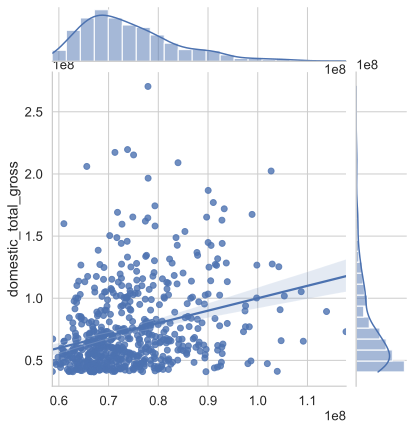

In [32]:
#still using training data
predict = lr.predict(X)  

sns.jointplot(x=predict,y=y, kind='reg')  


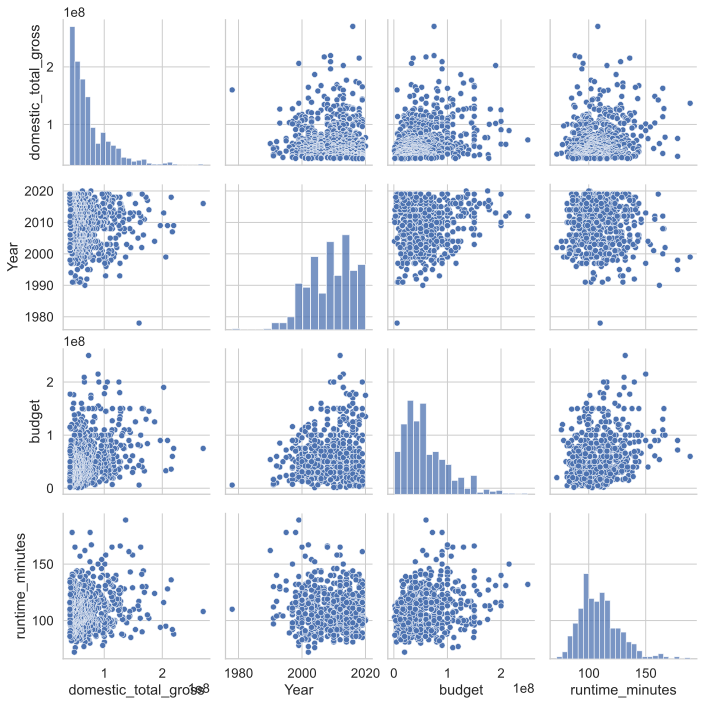

In [33]:
sns.pairplot(df_num)